## Lista 4 - rozwiązania

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import SnowballStemmer

import warnings

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Zadanie 1

W zadaniu 1 należało zaimplementować pipeline dla klasyfikacji tekstu z lepszą skutecznością niż model przedstawiony na wykładzie. Najpierw pobierzemy zbiór danych, na których będziemy trenować modele:

In [ ]:
from sklearn.datasets import fetch_20newsgroups
train = fetch_20newsgroups(subset='train', shuffle=True)
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Dodatkowo trzeba ściągnąć zbiór testowy:

In [ ]:
test = fetch_20newsgroups(subset='test', shuffle=True)

Do klasyfikacji tekstu użyjemy reprezentacji *bag-of-words*, czyli będziemy traktować wejściowy tekst jako zbiór słów jednocześnie ignorując porządek słów w tekście (potem można zastosować tzw. *n-gramy*, czyli stosować w procesie uczenia grupy $n$ słów następujących po sobie). Przed utworzeniem reprezentacji wektorowej słów występujących w poszczególnych dokumentach, najpierw dokonamy stemmingu, usunięcia *stop-words*, znaków interpunkcyjnych oraz każdą dużą litere w tekście zmienimy na małą:

In [ ]:
stemmer = SnowballStemmer(f'english', ignore_stopwords=True)

In [ ]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vectorizer = StemmedCountVectorizer(stop_words=f'english', lowercase=True)

Zbadajmy jeszcze jak zmienia się rozmiar macierzy z zakodowanym tekstem, po zastosowaniu powyższych procedur:

In [ ]:
X_train_counts = stemmed_count_vectorizer.fit_transform(train.data)
X_train_counts.shape

(11314, 110995)

Jak widać rozmiar otrzymanej macierzy jest mniejszy, niż rozmiar macierzy otrzymanej z mniej przetworzonego tekstu (wtedy ten rozmiar wynosił (11314, 130107)). Poniższy kod odpowiada za utworzenie pipeline'a. Do *ocenienia* sepcyficzności słów dla danego dokumentu, użyjemy wag ***tf-idf***, a jako klasyfikatora użyjemy lasy losowe:

In [ ]:
pipeline_classifier = Pipeline(
    [('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('rfclf', RandomForestClassifier(oob_score=True))]
)

pipeline_classifier = pipeline_classifier.fit(train.data, train.target)

Następnie zbadajmy skuteczność otrzymanego klasyfikatora:

In [ ]:
predictions = pipeline_classifier.predict(test.data)

print(f'Skuteczność otrzymanego klasyfikatora: {np.mean(predictions == test.target)}')
print(f'Out-of-bag error: {pipeline_classifier[2].oob_score_}')

Skuteczność otrzymanego klasyfikatora: 0.7590281465746149
Out-of-bag error: 0.8026339048965883


Spróbujmy zastosować *grid search* w celu dobrania najlepszych parametrów przy założeniu, że naszym modelem są lasy losowe. Za tą część odpowiada poniższy kod:

In [ ]:
parameters = {
    'vect__ngram_range': [(1, 1)],
    'tfidf__use_idf': [True, False],
}

In [ ]:
gs_clf = GridSearchCV(pipeline_classifier, parameters, n_jobs=-1)

gs_clf.fit(train.data, train.target)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

GridSearchCV(estimator=Pipeline(steps=[('vect', StemmedCountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('rfclf',
                                        RandomForestClassifier(oob_score=True))]),
             n_jobs=-1,
             param_grid={'tfidf__use_idf': [True, False],
                         'vect__ngram_range': [(1, 1)]})

Poniżej znadują się wyniki zwrócone przez wcześniejsze procedury:

In [ ]:
print(f'Najlepsza skuteczność: {gs_clf.best_score_}')
print(f'Najlepsze parametry: {gs_clf.best_params_}')

Najlepsza skuteczność: 0.8361320954125745
Najlepsze parametry: {'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


Następnie zobaczymy jak radzi sobie z tym zadaniem algorytm $k$-najbliższych sąsiadów:

In [ ]:
knn_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('knnclf', KNeighborsClassifier())])

Testowane parametry dla tego klasyfikatora:

In [ ]:
parameters = {
    'knnclf__n_neighbors': [5, 6, 7, 8],
    'tfidf__use_idf': [True, False]
}

Kolejne wyczerpujące przeszukiwanie przestrzeni parametrów:

In [ ]:
gs_clf = GridSearchCV(knn_pipeline, parameters, n_jobs=-1)

gs_clf.fit(train.data, train.target)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

/home/bw/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/bw/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

/home/bw/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/bw/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

GridSearchCV(estimator=Pipeline(steps=[('vect', StemmedCountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('knnclf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knnclf__n_neighbors': [5, 6, 7, 8],
                         'tfidf__use_idf': [True, False]})

Wyniki:

In [ ]:
print(f'Najlepsza skuteczność: {gs_clf.best_score_}')
print(f'Najlepsze parametry: {gs_clf.best_params_}')

Najlepsza skuteczność: 0.7828352386232527
Najlepsze parametry: {'knnclf__n_neighbors': 5, 'tfidf__use_idf': True}


Najczęściej polecanym modelem do klasyfikacji tekstu jest liniowy SVM. W związku z tym, również zbadamy jego działanie na naszym zbiorze danych:

In [ ]:
svm_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svmclf', SGDClassifier())])

Znowu ustalamy możliwe parametry:

In [ ]:
parameters = {
    'svmclf__loss': ['hinge', 'log_loss'],
    'svmclf__alpha': [1e-3],
    'svmclf__random_state': [42],
    'tfidf__use_idf': [True, False]
}

In [ ]:
gs_clf = GridSearchCV(svm_pipeline, parameters, n_jobs=-1)

gs_clf.fit(train.data, train.target)

GridSearchCV(estimator=Pipeline(steps=[('vect', StemmedCountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('svmclf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'svmclf__alpha': [0.001],
                         'svmclf__loss': ['hinge', 'log_loss'],
                         'svmclf__random_state': [42],
                         'tfidf__use_idf': [True, False]})

Wyniki:

In [ ]:
print(f'Najlepsza skuteczność: {gs_clf.best_score_}')
print(f'Najlepsze parametry: {gs_clf.best_params_}')

Najlepsza skuteczność: 0.8852752131021747
Najlepsze parametry: {'svmclf__alpha': 0.001, 'svmclf__loss': 'hinge', 'svmclf__random_state': 42, 'tfidf__use_idf': True}


Istotnie, najlepsza skuteczność została osiągnięta dla ostatniego estymatora i wynosi ona $88.5 \%$. Zatem przetesotwaliśmy $3$ rodzaje estymatorów i mamy następujący ranking: pierwsze miejsce - SVM, drugie miejsce - RFC i trzecie miejsce - KNN.

In [ ]:
parameters = {
    'vect__ngram_range': [(2, 2)],
    'svmclf__loss': ['hinge', 'log_loss'],
    'svmclf__alpha': [1e-3],
    'svmclf__random_state': [42],
    'tfidf__use_idf': [True, False]
}

In [ ]:
gs_clf = GridSearchCV(svm_pipeline, parameters, n_jobs=-1)

gs_clf.fit(train.data, train.target)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

GridSearchCV(estimator=Pipeline(steps=[('vect', StemmedCountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('svmclf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'svmclf__alpha': [0.001],
                         'svmclf__loss': ['hinge', 'log_loss'],
                         'svmclf__random_state': [42],
                         'tfidf__use_idf': [True, False],
                         'vect__ngram_range': [(2, 2)]})

In [ ]:
print(f'Najlepsza skuteczność: {gs_clf.best_score_}')
print(f'Najlepsze parametry: {gs_clf.best_params_}')

Najlepsza skuteczność: 0.8869541265262539
Najlepsze parametry: {'svmclf__alpha': 0.001, 'svmclf__loss': 'hinge', 'svmclf__random_state': 42, 'tfidf__use_idf': True, 'vect__ngram_range': (2, 2)}


Jak widać dla bigramów osięgneliśmy lepszą skuteczność modelu (na poziomie $88.6 \%$), jednak ta poprawa nie jest duża.

### Zadanie 2

W zadaniu 2 należało wykorzystać sieć neuronową pokazaną na wykładzie do rozwiązania problemu klasyfikacji z poprzedniego zadania. Wykorzystujemy ten sam zbiór danych co w poprzednim zadaniu. Przed zbudowaniem sieci neuronowej i uruchomieniem trenowania najpierw trzeba odpowiednio przetworzyć dane wejściowe. Zobaczmy ile jest kategorii i w jaki sposób są reprezentowane:

In [ ]:
train.target[:20]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4,  8, 19,  4, 14,  6,  0,  1,
        7, 12,  5])

Jak widać jest $20$ kategorii reprezentowanych jako liczby całkowite ze zbioru $\{0, \ldots, 19\}$. W następnym kroku znowu utrzorzymy macierz z daymi treningowymi (ta sama procedura tj. stemming, usuwanie "stop-words" itd. jak poprzednio):

In [ ]:
stemmed_count_vectorizer = StemmedCountVectorizer(stop_words=f'english', lowercase=True)
X = stemmed_count_vectorizer.fit_transform(train.data)

s = np.sum(X, axis=0)
_, cols = s.shape

W wektorach będziemy używać wag Tf-idf:

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X)

In [ ]:
X_train.shape

(11314, 110995)

Każdy wiersz powyższej macierzy jest tak naprawde wektorem ze zmiennymi binarnymi. Zatem suma wartości w poszczególnych kolumnach będzie odpowiadała liczbie wystąpień danego słowa we wszystkich dokumentach:

In [ ]:
cols

110995

Tworzymy słownik z numerami kolejnych kolumn jako klucze i liczbami wystąpień jako wartości:

In [ ]:
occurences_dictionary = {i:s[0, i] for i in range(0, cols)}

Sortujemy słownik w kolejności malejącej po wartościach:

In [ ]:
sorted_occurences_dictionary = {k: v for k, v in sorted(occurences_dictionary.items(), key=lambda x: x[1], reverse=True)}

W celu zmniejszenia rozmiaru wektorów wejściowych, będziemy brać tylko $n$ najczęściej występujących słów:

In [ ]:
top_n_words = 15000

desired_columns = list(sorted_occurences_dictionary.keys())[:top_n_words]

X_train = X_train.toarray()

X_train = X_train[:, desired_columns]

Weryfikacja, że wszystko działa poprawnie:

In [ ]:
X_train.shape

(11314, 400)

Następnie tworzymy architekture sieci neuronowej:

In [ ]:
from keras import models
from keras import layers


network = models.Sequential()
network.add(layers.Dense(2000, activation='relu', input_shape=(15000,)))
network.add(layers.Dense(2000, activation='relu'))
network.add(layers.Dense(20, activation='softmax'))

network.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

W następnym kroku, nadal dostosowuje dane treningowe do sieci neuronowej. Sieć neuronowa ma $20$ wyjść, które modelują pewien rozkład prawdopodobieństwa. Z tego względu odpowiedzi trzeba zakodować w podobny sposób. Wykorzystamy do tego dobrze znany "one-hot encoding" (czyli wektor z $20$ pozycjami ; $1$ jest na przewidywanej pozycji (kategorii) a reszta to $0$):

In [ ]:
from keras.utils import to_categorical

train_labels_one_hot = to_categorical(train.target)
test_labels_one_hot = to_categorical(test.target)

Sprawdźmy, czy wszystko jest ok:

In [ ]:
train_labels_one_hot.shape

(11314, 20)

In [ ]:
test_labels_one_hot.shape

(7532, 20)

Teraz dostosujemy dane testowe do sieci neuronowej (podobna procedura co dla danych treningowych):

In [ ]:
X_test = stemmed_count_vectorizer.fit_transform(test.data)

s = np.sum(X_test, axis=0)

_, cols = s.shape

X_test = tfidf_transformer.fit_transform(X_test)

occurences_dictionary = {i:s[0, i] for i in range(0, cols)}
sorted_occurences_dictionary = {k: v for k, v in sorted(occurences_dictionary.items(), key=lambda x: x[1], reverse=True)}

desired_columns = list(sorted_occurences_dictionary.keys())[:top_n_words]

X_test = X_test.toarray()

X_test = X_test[:, desired_columns]

X_test.shape

(7532, 15000)

In [ ]:
history = network.fit(
    X_train,
    train_labels_one_hot,
    epochs=30, 
    batch_size=700,
    validation_data=(X_test, test_labels_one_hot)
)

Epoch 1/30
17/17 [==============================] - 6s 233ms/step - loss: 1.5044 - accuracy: 0.6048 - val_loss: 3.4995 - val_accuracy: 0.0531
Epoch 2/30
17/17 [==============================] - 1s 68ms/step - loss: 0.2232 - accuracy: 0.9530 - val_loss: 4.8446 - val_accuracy: 0.0482
Epoch 3/30
17/17 [==============================] - 1s 67ms/step - loss: 0.0762 - accuracy: 0.9842 - val_loss: 3.9454 - val_accuracy: 0.0499
Epoch 4/30
17/17 [==============================] - 1s 67ms/step - loss: 0.0228 - accuracy: 0.9961 - val_loss: 4.1412 - val_accuracy: 0.0516
Epoch 5/30
17/17 [==============================] - 1s 68ms/step - loss: 0.0112 - accuracy: 0.9980 - val_loss: 4.4614 - val_accuracy: 0.0539
Epoch 6/30
17/17 [==============================] - 1s 68ms/step - loss: 0.0083 - accuracy: 0.9984 - val_loss: 5.8982 - val_accuracy: 0.0516
Epoch 7/30
17/17 [==============================] - 1s 67ms/step - loss: 0.0111 - accuracy: 0.9971 - val_loss: 5.3315 - val_accuracy: 0.0566
Epoch 8/30
1

Narysujmy pare wykresów:

In [ ]:
history_dict = history.history

print(history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = len(accuracy)
ep = list(range(1, epochs))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Wykres zależności straty od epoki:

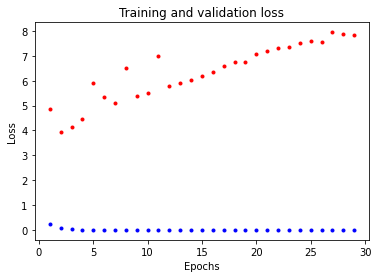

In [ ]:
plt.title(f'Training and validation loss')

plt.xlabel(f'Epochs')
plt.ylabel(f'Loss')

plt.plot(ep, loss[1:epochs], '.', color='blue')
plt.plot(ep, val_loss[1:epochs], '.', color='red')

Wykres zależności skuteczności na zbiorach treningowym i walidacyjnym w zależności od epoki:

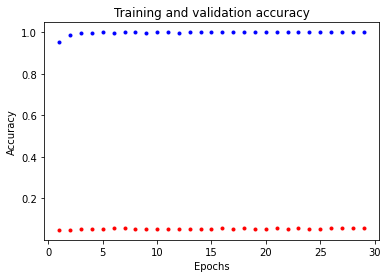

In [ ]:
plt.title(f'Training and validation accuracy')

plt.xlabel(f'Epochs')
plt.ylabel(f'Accuracy')

plt.plot(ep, accuracy[1:epochs], '.', color='blue')
plt.plot(ep, val_accuracy[1:epochs], '.', color='red')

Po sprawdzeniu różnych parametrów i przeprowadzeniu eksperymentów można stwierdzić, że w tym przypadku ograniczenie na liczbę najczęściej występujących słów ($n = 15000$) jest za małe (w porównaniu do liczby kolumn w oryginalnym zbiorze testowym), aby osiągnąć jakąś sensowną skuteczność na zbiorze walidacyjnym. Z wykresów widać, że nawet dla tak dużego  $n$ sieć neuronowa po prostu overfittuje (skuteczność na zbiorze treningowym równa prawie $100 \%$). Po empirycznym sprawdzeniu, doszedłem do wniosku, że dodawanie kolejnych warstw ukrytych do sieci, jeszcze bardziej pogrszało overfitting (co jest normalne w przypadku sieci neuronowych). Z kolei zwiększanie *batch size* poprawia skuteczność na zbiorze walidacyjnym, ale wydłuża proces uczenia sieci neuronowej. Stosowanie większych warstw również pomaga w osiągnięciu lepszej skuteczności (dlatego, bo dodajemy niezbyt dużo (w porównaniu do dodania nowej warstwy) nowych parametrów, które mogą się okazać pomocne w zadaniu klasyfikacji). Dodatkowo zwiększanie liczby epok mogło powodować (w tym przypadku) jeszcze gorszy overfitting (sprawdzano dla liczby epok $e = 50$, ale później zmieniłem na $e = 30$ - to widać z wykresów).